In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split


config = dict(
    batch_size=2048,
    model_name='U-Net Simple',
    epochs=100,
    init_learning_rate=0.0001,
    lr_decay_rate=0.1,
    optimizer='adam',
    loss_fn='mean_squared_error',
    earlystopping_patience=10,
)

# Assuming your model is saved in this path
model_path = '/home/nicosepulveda/astro/bridge/model/local_1st_best_model/model-best.h5'

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Define a bottleneck model to extract features from the bottleneck layer and apply global average pooling
bottleneck_output = model.get_layer('pre_bottleneck').output
global_avg_pooling = GlobalAveragePooling2D()(bottleneck_output)
bottleneck_model = Model(inputs=model.input, outputs=global_avg_pooling)

# Normalization functions (from your code)
@tf.function
def normalize_images(images):
    img1, img2, diff_img = tf.unstack(images, axis=0)  # Unstack into three separate images
    combined = tf.stack([img1, img2], axis=0)  # Stack img1 and img2 for min/max calculation
    min_val = tf.reduce_min(combined)
    max_val = tf.reduce_max(combined)
    img1_rescaled = (img1 - min_val) / (max_val - min_val)
    img2_rescaled = (img2 - min_val) / (max_val - min_val)
    return img1_rescaled, img2_rescaled, diff_img

@tf.function
def normalize_difference_based_on_range(img1, img2, diff_img):
    difference = img1 - img2
    min_diff = tf.reduce_min(difference, keepdims=True)
    max_diff = tf.reduce_max(difference, keepdims=True)
    diff_img_rescaled = 2 * (diff_img - min_diff) / (max_diff - min_diff) - 1
    return diff_img_rescaled

@tf.function
def preprocess_image(images):
    img1, img2, diff_img = normalize_images(images)
    diff_img_rescaled = normalize_difference_based_on_range(images[0], images[1], images[2])
    input_img = tf.stack([img1, img2], axis=-1)  # Stack along the channel dimension
    input_img = tf.image.crop_to_bounding_box(input_img, 7, 7, 48, 48) #crop

    diff_img_rescaled = tf.expand_dims(diff_img_rescaled, axis=-1)  # Ensure correct shape for output
    diff_img_rescaled = tf.image.crop_to_bounding_box(diff_img_rescaled, 7, 7, 48, 48) #crop

    return input_img, diff_img_rescaled

def _parse_function(proto):
    keys_to_features = {
        'images': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_features = tf.io.parse_single_example(proto, keys_to_features)
    images = tf.io.parse_tensor(parsed_features['images'], out_type=tf.float32)
    images = tf.reshape(images, [3, 63, 63])  # Three images each 63x63
    images = tf.where(tf.math.is_nan(images), tf.zeros_like(images), images)
    return images

def load_dataset(tfrecord_paths, batch_size):
    dataset = tf.data.TFRecordDataset(tfrecord_paths)
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    #dataset = dataset.repeat()
    return dataset

# Setup dataset
tfrecord_folder_path = "/home/nicosepulveda/astro/bridge/TFRecords"
all_tfrecord_paths = [str(path) for path in Path(tfrecord_folder_path).glob('*.tfrecord')][0:1000]
train_paths, test_val_paths = train_test_split(all_tfrecord_paths, test_size=0.3, random_state=1)
val_paths, test_paths = train_test_split(test_val_paths, test_size=0.5, random_state=2)

test_dataset = load_dataset(test_paths, batch_size=config['batch_size'])
val_dataset = load_dataset(val_paths, batch_size=config['batch_size'])

def extract_bottleneck_features(dataset, batch_size, num_batches=None):
    features = []
    indices = []
    batch_count = 0
    index = 0
    for batch in dataset:
        inputs, _ = batch
        batch_features = bottleneck_model.predict(inputs)
        features.append(batch_features)
        indices.extend(range(index, index + len(inputs)))
        index += len(inputs)
        batch_count += 1
        if num_batches and batch_count >= num_batches:
            break
    return np.concatenate(features, axis=0), indices

# Adjust the number of batches to process to fit in memory
num_batches_to_process = 50

# Extract bottleneck features and global average pool them
val_bottleneck_features, val_indices = extract_bottleneck_features(val_dataset, config['batch_size'], num_batches_to_process)


2025-01-10 11:27:50.888688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-10 11:27:51.414489: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2025-01-10 11:27:51.414529: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2025-01-10 11:27:51.414534: W tensorflow/compiler/tf2tensorrt/utils/py_uti

64/64 [==============================] - 0s 2ms/step


In [ ]:
pip install umap-learn

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt

# Normalize Bottleneck Features
scaler = StandardScaler()
val_bottleneck_features = scaler.fit_transform(val_bottleneck_features.reshape(len(val_bottleneck_features), -1))

print(val_bottleneck_features.shape)



(102400, 512)


/home/nicosepulveda/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


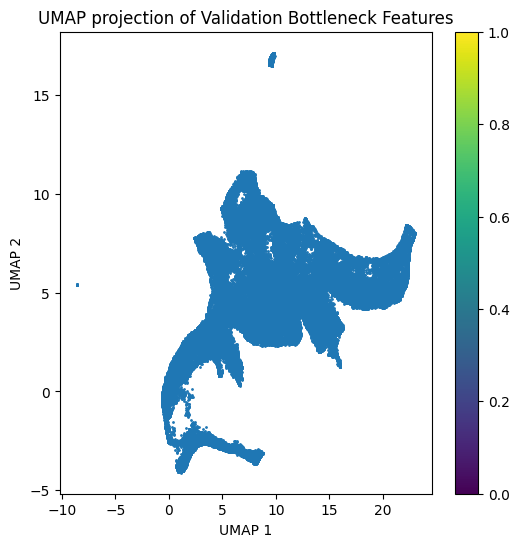

In [3]:
# Apply UMAP with adjusted parameters for more spread-out clusters
reducer = umap.UMAP(n_neighbors=15, min_dist=0.05)
val_embedding = reducer.fit_transform(val_bottleneck_features)

# Plot the UMAP results
plt.figure(figsize=(6, 6))
plt.scatter(val_embedding[:, 0], val_embedding[:, 1], s=1)
plt.title('UMAP projection of Validation Bottleneck Features')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar()
plt.show()


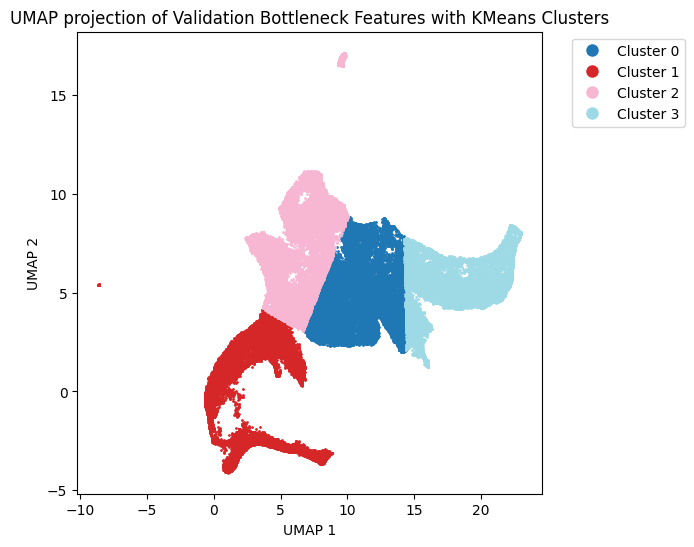

In [10]:
# Generate some sample UMAP data for demonstration
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D

# Apply KMeans clustering
num_clusters = 4  # Adjust the number of clusters based on your data
kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(val_embedding)
val_clusters = kmeans.labels_

# Plot the UMAP results with clusters
plt.figure(figsize=(6, 6))

# Assign colors to clusters
unique_clusters = np.unique(val_clusters)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

for cluster, color in zip(unique_clusters, colors):
    plt.scatter(val_embedding[val_clusters == cluster, 0], val_embedding[val_clusters == cluster, 1], color=color, s=1, label=f'Cluster {cluster}')

plt.title('UMAP projection of Validation Bottleneck Features with KMeans Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Create custom legend handles
legend_elements = []
for cluster, color in zip(unique_clusters, colors):
    legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Cluster {cluster}'))

plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [5]:
pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 3.0 MB/s eta 0:00:00 MB/s eta 0:00:01:01m
Note: you may need to restart the kernel to use updated packages.


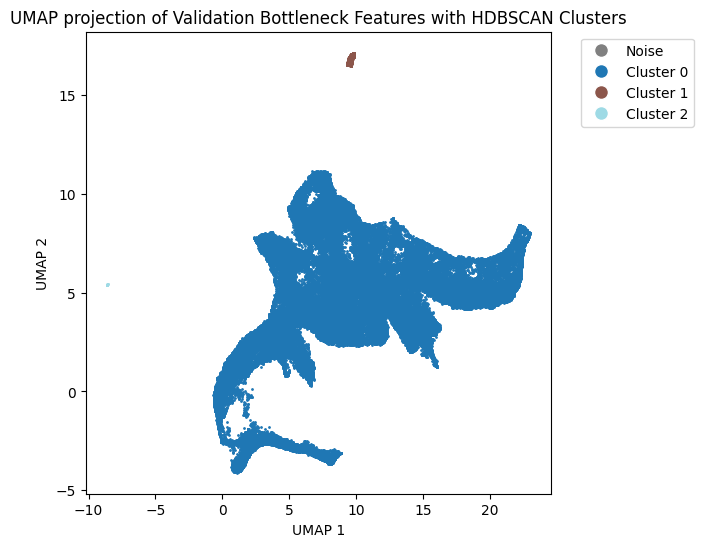

In [13]:
from sklearn.cluster import dbscan
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Apply HDBSCAN clustering with adjusted parameters for bigger clusters
clusterer, val_clusters = dbscan(val_embedding, eps=0.5,  min_samples=15)

# Plot the UMAP results with clusters
plt.figure(figsize=(6, 6))

# Assign colors to clusters
unique_clusters = np.unique(val_clusters)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

for cluster, color in zip(unique_clusters, colors):
    if cluster == -1:
        # Noise points
        plt.scatter(val_embedding[val_clusters == cluster, 0], val_embedding[val_clusters == cluster, 1], color='gray', s=1, label='Noise')
    else:
        plt.scatter(val_embedding[val_clusters == cluster, 0], val_embedding[val_clusters == cluster, 1], color=color, s=1, label=f'Cluster {cluster}')

plt.title('UMAP projection of Validation Bottleneck Features with HDBSCAN Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

# Create custom legend handles
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=10, label='Noise')]
for cluster, color in zip(unique_clusters, colors):
    if cluster != -1:
        legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=f'Cluster {cluster}'))

plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Número de puntos ruidosos: 0
No noise points to process.


IndexError: arrays used as indices must be of integer (or boolean) type

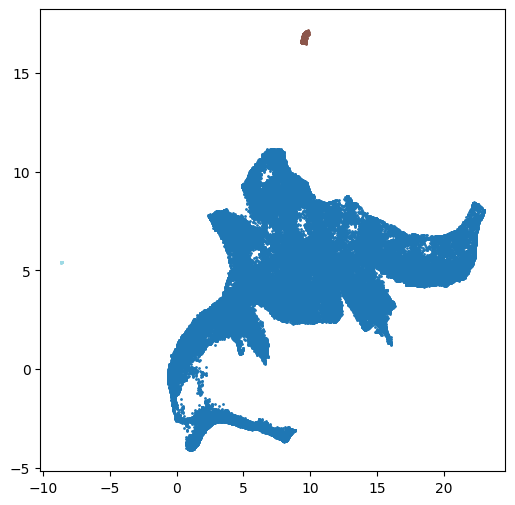

In [9]:
import hdbscan
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min

# Identify and visualize the most extreme noise points
val_noise_points = val_embedding[val_clusters == -1]
# Verificar el tamaño de los puntos ruidosos
print("Número de puntos ruidosos:", len(val_noise_points))

# Find the most extreme points (furthest from any cluster)
def find_extreme_points(noise_points, clusters_embedding, all_indices):
    if len(noise_points) == 0:
        print("No noise points to process.")
        return np.array([]), np.array([])    
    distances = pairwise_distances_argmin_min(noise_points, clusters_embedding)[1]
    extreme_indices = np.argsort(distances)[-10:]  # Get the indices of the 10 most extreme points
    return extreme_indices, all_indices[extreme_indices]

val_extreme_points_indices, val_extreme_global_indices = find_extreme_points(val_noise_points, val_embedding[val_clusters != -1], np.array(val_indices)[val_clusters == -1])

# Plot the extreme noise points
plt.figure(figsize=(6, 6))

# Assign colors to clusters
unique_clusters = np.unique(val_clusters)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

for cluster, color in zip(unique_clusters, colors):
    if cluster == -1:
        # Noise points
        plt.scatter(val_embedding[val_clusters == cluster, 0], val_embedding[val_clusters == cluster, 1], color='gray', s=1, label='Noise')
    else:
        plt.scatter(val_embedding[val_clusters == cluster, 0], val_embedding[val_clusters == cluster, 1], color=color, s=1, label=f'Cluster {cluster}')

# Highlight extreme noise points
plt.scatter(val_noise_points[val_extreme_points_indices, 0], val_noise_points[val_extreme_points_indices, 1], c='red', label='Extreme Noise Points', s=10)
plt.title('UMAP projection of Validation Bottleneck Features with Extreme Noise Points')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Print the indices of the extreme noise points
print("Validation extreme noise points indices:", val_extreme_points_indices)


In [ ]:
# # Visualization function for anomalies
# def visualize_anomalies(anomaly_indices, dataset, model):
#     for batch_idx, batch in enumerate(dataset):
#         inputs, outputs = batch
#         # Check if any anomaly indices are in the current batch
#         relevant_indices = [idx for idx in anomaly_indices if idx // config['batch_size'] == batch_idx]
#         if relevant_indices:
#             # Get the predictions for the current batch
#             predictions = model.predict(inputs)
#             for idx in relevant_indices:
#                 # Determine the index within the batch
#                 img_idx = idx % config['batch_size']
                
#                 img1, img2 = inputs[img_idx, :, :, 0], inputs[img_idx, :, :, 1]
#                 diff_img = outputs[img_idx, :, :, 0]
#                 pred_img = predictions[img_idx, :, :, 0]

#                 plt.figure(figsize=(15, 5))
                
#                 plt.subplot(1, 4, 1)
#                 plt.imshow(np.log10(img1), cmap='gray')
#                 plt.title('New Image')

#                 plt.subplot(1, 4, 2)
#                 plt.imshow(np.log10(img2), cmap='gray')
#                 plt.title('Reference Image')

#                 plt.subplot(1, 4, 3)
#                 plt.imshow(diff_img, cmap='gray')
#                 plt.title('Difference Image')

#                 plt.subplot(1, 4, 4)
#                 plt.imshow(pred_img, cmap='gray')
#                 plt.title('Predicted Difference')

#                 plt.show()

# # Call the function with anomaly indices and the validation dataset
# visualize_anomalies(val_extreme_points_indices, val_dataset, model)

Cluster 0:
64/64 [==============================] - 1s 6ms/step


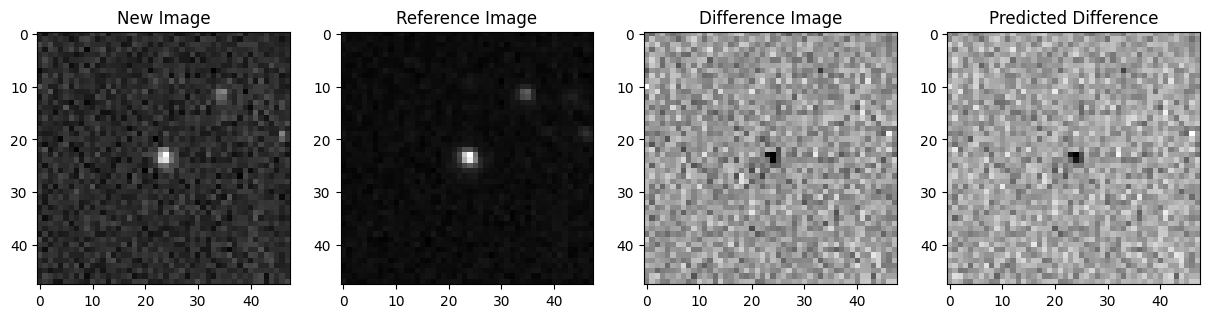

64/64 [==============================] - 0s 6ms/step


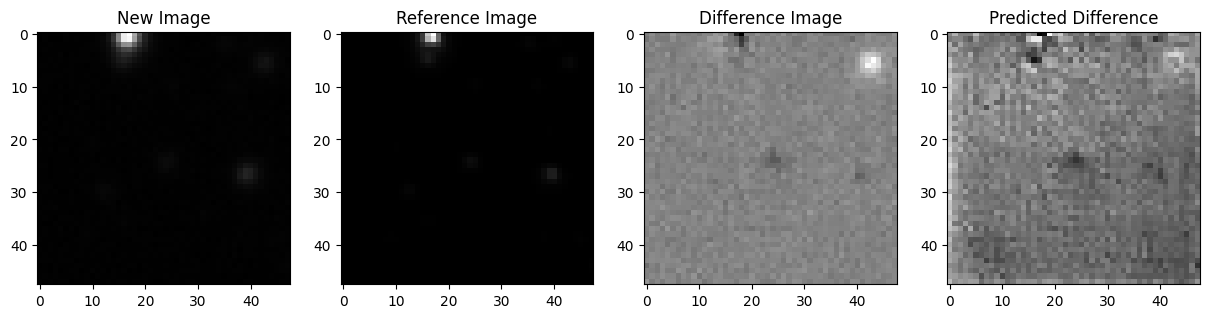

64/64 [==============================] - 0s 6ms/step


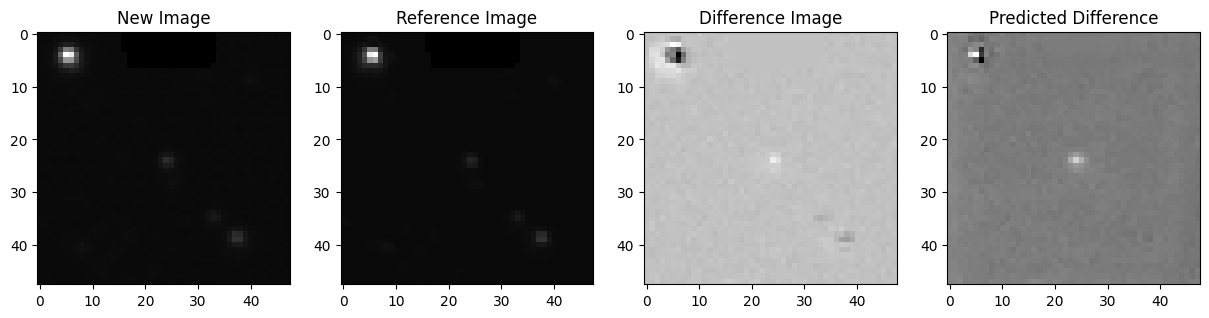

Cluster 1:
64/64 [==============================] - 0s 6ms/step


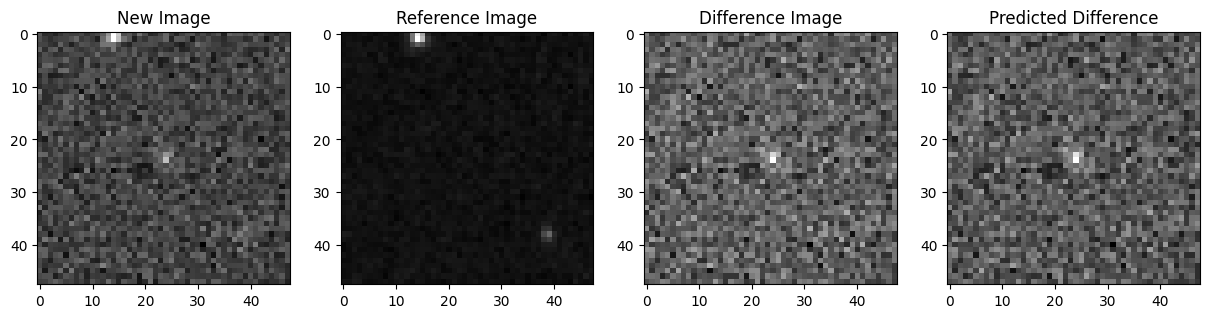

64/64 [==============================] - 0s 6ms/step


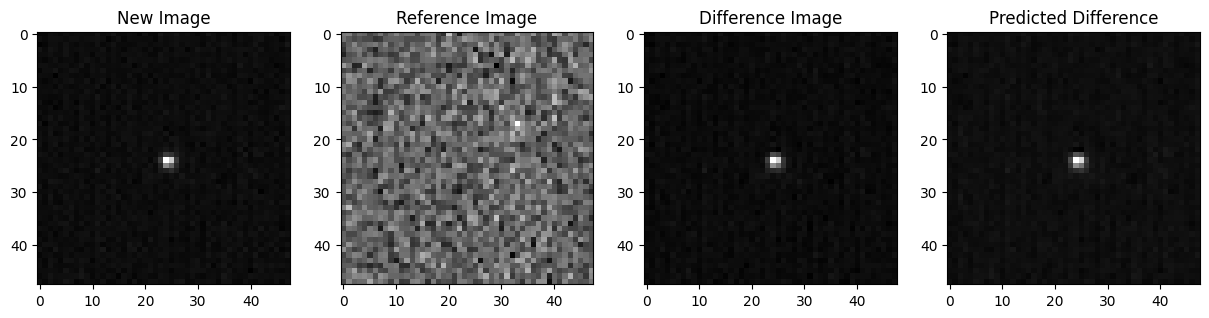

64/64 [==============================] - 0s 6ms/step


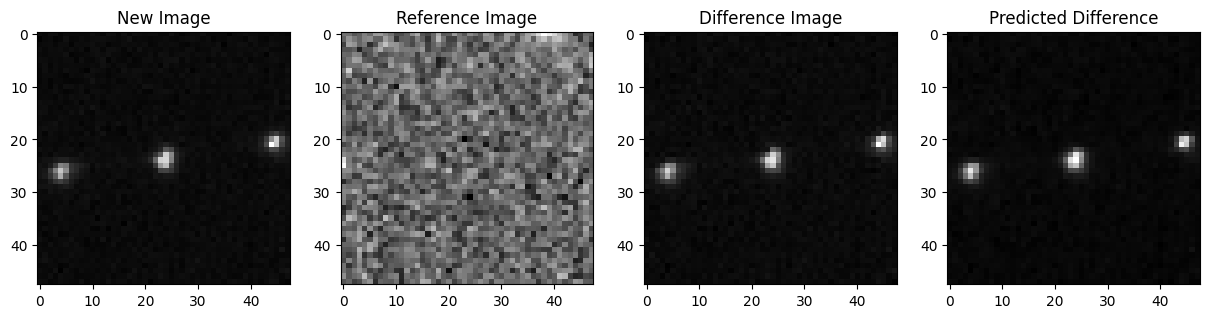

Cluster 2:
64/64 [==============================] - 0s 6ms/step


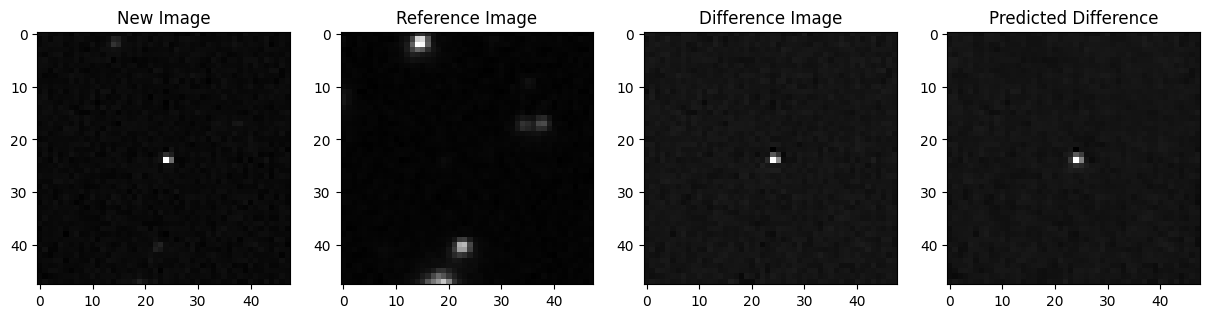

64/64 [==============================] - 0s 6ms/step


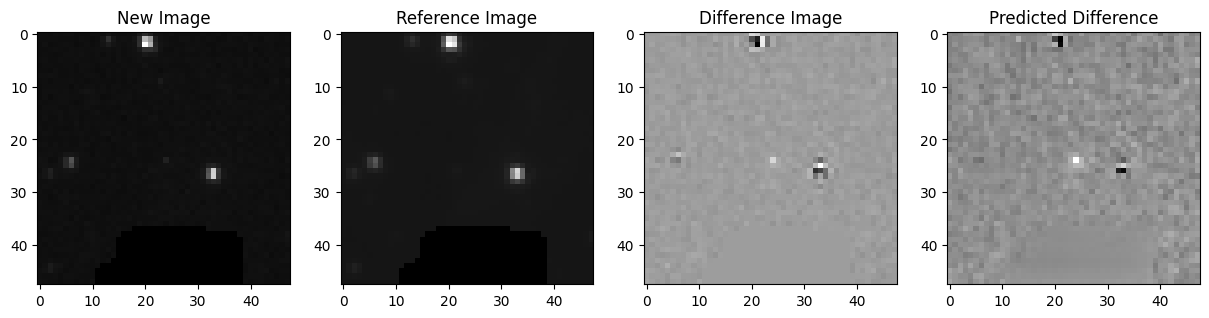

64/64 [==============================] - 0s 6ms/step


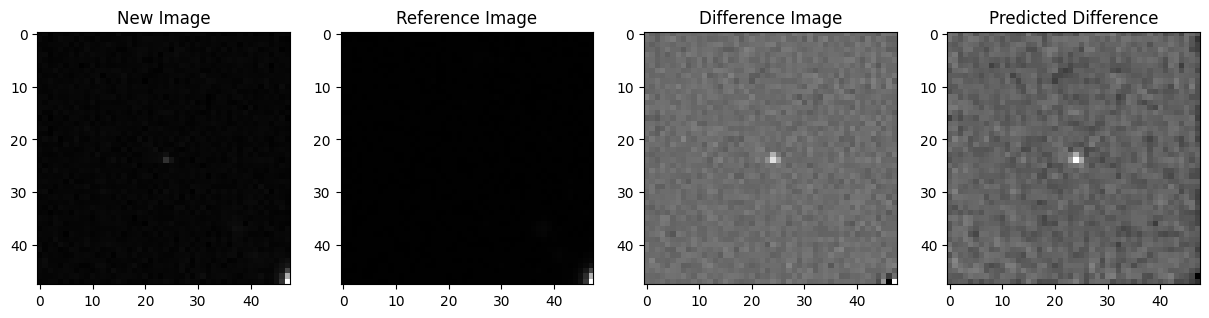

Cluster 3:
64/64 [==============================] - 0s 6ms/step


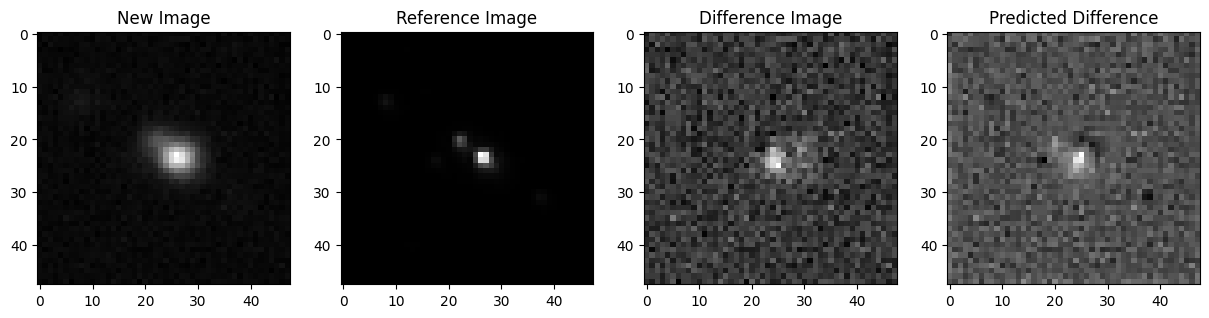

64/64 [==============================] - 0s 6ms/step


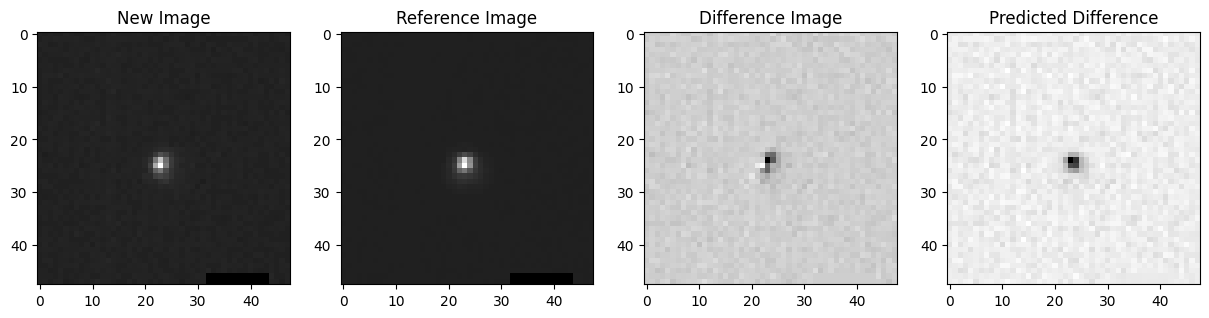

64/64 [==============================] - 0s 6ms/step


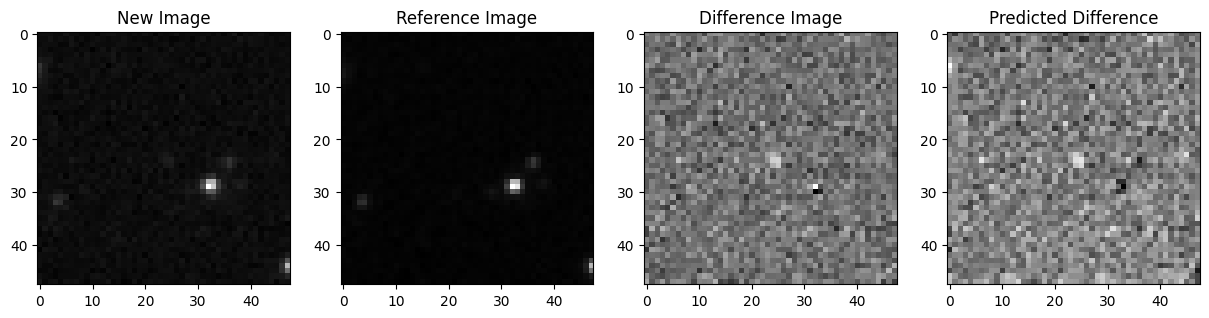

In [11]:
import matplotlib.pyplot as plt

def visualize_cluster_examples(cluster_indices, dataset, model, num_examples=3):
    for cluster in np.unique(cluster_indices):
        if cluster == -1:
            continue  # Skip noise cluster
        print(f"Cluster {cluster}:")
        cluster_points = np.where(cluster_indices == cluster)[0]
        selected_points = np.random.choice(cluster_points, min(num_examples, len(cluster_points)), replace=False)
        
        for idx in selected_points:
            for batch_idx, batch in enumerate(dataset):
                inputs, outputs = batch
                if idx // config['batch_size'] == batch_idx:
                    img_idx = idx % config['batch_size']
                    
                    img1, img2 = inputs[img_idx, :, :, 0], inputs[img_idx, :, :, 1]
                    diff_img = outputs[img_idx, :, :, 0]
                    pred_img = model.predict(inputs)[img_idx, :, :, 0]

                    plt.figure(figsize=(15, 5))

                    plt.subplot(1, 4, 1)
                    plt.imshow((img1), cmap='gray')
                    plt.title('New Image')

                    plt.subplot(1, 4, 2)
                    plt.imshow((img2), cmap='gray')
                    plt.title('Reference Image')

                    plt.subplot(1, 4, 3)
                    plt.imshow(diff_img, cmap='gray')
                    plt.title('Difference Image')

                    plt.subplot(1, 4, 4)
                    plt.imshow(pred_img, cmap='gray')
                    plt.title('Predicted Difference')

                    plt.show()
                    break  # Break after plotting the image

# Call the function with the cluster indices and validation dataset
visualize_cluster_examples(val_clusters, val_dataset, model)


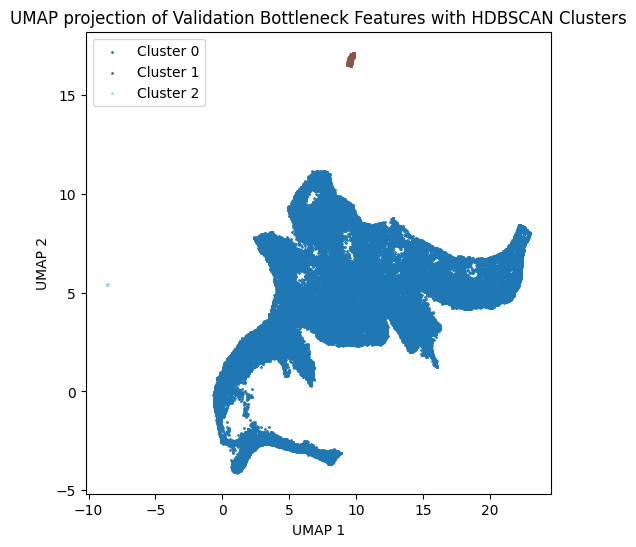

Cluster 0:
64/64 [==============================] - 0s 6ms/step


/tmp/ipykernel_30479/1516183620.py:53: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img1), cmap='gray')


64/64 [==============================] - 0s 6ms/step


/tmp/ipykernel_30479/1516183620.py:57: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img2), cmap='gray')


64/64 [==============================] - 0s 6ms/step
Cluster 1:
64/64 [==============================] - 0s 6ms/step


/tmp/ipykernel_30479/1516183620.py:57: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img2), cmap='gray')


64/64 [==============================] - 0s 6ms/step
Cluster 2:
64/64 [==============================] - 0s 6ms/step


In [14]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os

# Ensure the PLOTS directory exists
os.makedirs('PLOTS', exist_ok=True)

# Plot the UMAP results with clusters and save the plot
plt.figure(figsize=(6, 6))

# Assign colors to clusters
unique_clusters = np.unique(val_clusters)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

for cluster, color in zip(unique_clusters, colors):
    if cluster == -1:
        # Noise points
        plt.scatter(val_embedding[val_clusters == cluster, 0], val_embedding[val_clusters == cluster, 1], color='gray', s=1, label='Noise')
    else:
        plt.scatter(val_embedding[val_clusters == cluster, 0], val_embedding[val_clusters == cluster, 1], color=color, s=1, label=f'Cluster {cluster}')

plt.title('UMAP projection of Validation Bottleneck Features with HDBSCAN Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(loc='upper left')

umap_plot_path = 'PLOTS/umap_clusters.pdf'
plt.savefig(umap_plot_path)
plt.show()

def visualize_cluster_examples(cluster_indices, dataset, model, num_examples=20):
    for cluster in np.unique(cluster_indices):
        if cluster == -1:
            continue  # Skip noise cluster
        print(f"Cluster {cluster}:")
        cluster_points = np.where(cluster_indices == cluster)[0]
        selected_points = np.random.choice(cluster_points, min(num_examples, len(cluster_points)), replace=False)
        
        with PdfPages(f'PLOTS/cluster_{cluster}.pdf') as pdf:
            for idx in selected_points:
                for batch_idx, batch in enumerate(dataset):
                    inputs, outputs = batch
                    if idx // config['batch_size'] == batch_idx:
                        img_idx = idx % config['batch_size']
                        
                        img1, img2 = inputs[img_idx, :, :, 0], inputs[img_idx, :, :, 1]
                        diff_img = outputs[img_idx, :, :, 0]
                        pred_img = model.predict(inputs)[img_idx, :, :, 0]

                        plt.figure(figsize=(15, 5))

                        plt.subplot(1, 4, 1)
                        plt.imshow(np.log10(img1), cmap='gray')
                        plt.title('New Image')

                        plt.subplot(1, 4, 2)
                        plt.imshow(np.log10(img2), cmap='gray')
                        plt.title('Reference Image')

                        plt.subplot(1, 4, 3)
                        plt.imshow(diff_img, cmap='gray')
                        plt.title('Difference Image')

                        plt.subplot(1, 4, 4)
                        plt.imshow(pred_img, cmap='gray')
                        plt.title('Predicted Difference')

                        pdf.savefig()  # Save the current figure into the PDF
                        plt.close()
                        break  # Break after plotting the image

# Call the function with the cluster indices and validation dataset
visualize_cluster_examples(val_clusters, val_dataset, model)
